In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

In [2]:
###### Fucntion for creating random adjacency matrix. #########

def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(0,number_of_vertices):
            if random.random()>probability:
                adj_matrix[i,j]=0

    return adj_matrix

In [3]:
###### Function for converting binary number to decimal #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    
    return binary

In [4]:
####### Using Brute force ########

def brute_force(n, adj_matrix):
    best_cost = 0
    best_case = None
    for k in range(2**n):
        binary_k=dec_to_bin(k, n)
        temp_cost = 0
        for i in range(n):
            for j in range(n):
                temp_cost = temp_cost + adj_matrix[i,j]*binary_k[i]*(1-binary_k[j])
        if temp_cost > best_cost:
            best_cost = temp_cost
            best_case = binary_k

    return best_cost

In [5]:
######## function for getting n dependant cost and time using brute force ##########
def get_cost_and_time_vs_n(n1, n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(brute_force(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n.append((x, y))
        time_vs_n.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n, time_vs_n

In [6]:
######## Function for getting cost using numpyeigensolver ############
def using_numpyeigensolver(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = IsingToQuadraticProgram()
    qudratic_problem = qudratic.encode(qubitop, offset)
    solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = solver.solve(qudratic_problem)
    best_cost = float(str(result).split('-')[1])
    return best_cost


In [7]:
########  function for getting n dependant cost and time using Numpyeigensolver #########
def get_cost_and_time_numpyeigensolver(n1, n2):
    cost_vs_n_fromeigensolver = list()
    time_vs_n_fromeigensolver = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(using_numpyeigensolver(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromeigensolver.append((x, y))
        time_vs_n_fromeigensolver.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver

In [8]:
######## getting cost and time from every method #########

print("Cost and time using Brute Force")
cost_vs_n, time_vs_n = get_cost_and_time_vs_n(4, 15)

print("")

print("Cost and time using NumpyEigenSolver")
cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver = get_cost_and_time_numpyeigensolver(4, 15)

Cost and time using Brute Force
n= 4 cost= 2.8 time= 0.0003989219665527344
n= 5 cost= 4.6 time= 0.0009976863861083985
n= 6 cost= 7.0 time= 0.00319819450378418
n= 7 cost= 9.2 time= 0.006581544876098633
n= 8 cost= 12.4 time= 0.015031909942626953
n= 9 cost= 13.2 time= 0.04029269218444824
n= 10 cost= 17.2 time= 0.0913623332977295
n= 11 cost= 21.0 time= 0.21642088890075684
n= 12 cost= 25.4 time= 0.5477410793304444
n= 13 cost= 30.0 time= 1.2295048713684082
n= 14 cost= 33.0 time= 2.7862698554992678

Cost and time using NumpyEigenSolver
n= 4 cost= 2.6 time= 0.012766742706298828
n= 5 cost= 4.0 time= 0.01514263153076172
n= 6 cost= 5.8 time= 0.020544672012329103
n= 7 cost= 7.6 time= 0.027600479125976563
n= 8 cost= 12.0 time= 0.03969388008117676
n= 9 cost= 13.6 time= 0.06422796249389648
n= 10 cost= 15.8 time= 0.035704612731933594
n= 11 cost= 22.4 time= 0.05603218078613281
n= 12 cost= 23.6 time= 0.07360506057739258
n= 13 cost= 27.2 time= 0.11190061569213867
n= 14 cost= 33.6 time= 0.2128245353698730

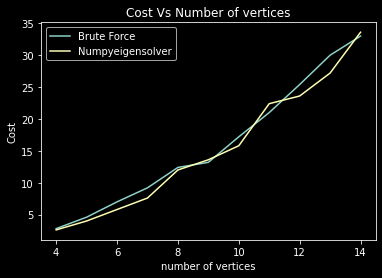

In [9]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
x, y = zip(*cost_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*cost_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs)>

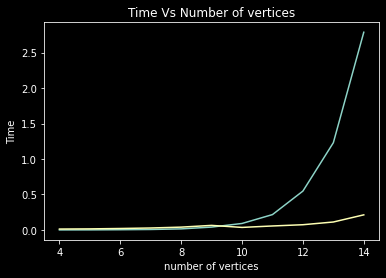

In [10]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
x, y = zip(*time_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*time_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
plt.legend()